# My page

In [1]:
import os
import numpy as np
import keras_cv
import keras
import tensorflow as tf
import pycocotools
import math
from keras import utils as kutils
from keras_cv import visualization

BATCH_SIZE=4
SET_NAME='set1'

def dataset_generator_builder(set_name, bounding_box_format, filter):
  def generator():
    print('Using set :', set_name, ' with filter :', filter)
    root = os.path.join('data', set_name, filter)
    # Gather images from dir
    img_dir = os.path.join(root, 'images')
    img_names = os.listdir(img_dir)
    # Get labels
    bounding_boxes_dir = os.path.join(root, 'labels')
    # Get classnames
    classes = os.path.join(root, 'classes')
    images = []
    
    for i in img_names:
      image = kutils.load_img(os.path.join(img_dir, i))
      boxes = []
      classes = []
      with open(os.path.join(bounding_boxes_dir, os.path.splitext(i)[0] + '.txt')) as labels_file:
        lines = labels_file.readlines()
        for line in lines:
          line_array = line.replace('\n', '').split(' ')
          class_index = int(line_array[0])
          boxes.append([
            float(line_array[1]),
            float(line_array[2]),
            float(line_array[3]),
            float(line_array[4])
          ])
          classes.append(class_index)
      
      boxes_array = np.array(boxes)
      img_array = keras.utils.img_to_array(image)
      centered_boxes = keras_cv.bounding_box.convert_format(
        boxes_array,
        images=img_array,
        source="rel_xywh",
        target=bounding_box_format,
      )
      converted_boxes = keras_cv.bounding_box.convert_format(
        centered_boxes,
        images=img_array,
        source="center_xyWH",
        target=bounding_box_format,
      )
      images.append({
        'images': np.array(img_array),
        'bounding_boxes': {
          'boxes': converted_boxes,
          'classes': np.array(classes)
        }
      })


    return images
  
  return generator

train_ds = tf.data.Dataset.from_generator(
  dataset_generator_builder(SET_NAME, 'xywh', filter='train'),
  output_types={ 'images': tf.float32, 'bounding_boxes': { 'boxes': tf.float32, 'classes': tf.int32 } },
  output_shapes={ 'images': (None,None,3), 'bounding_boxes': { 'boxes': (None,4), 'classes': (None,) } },
)

eval_ds = tf.data.Dataset.from_generator(
  dataset_generator_builder(SET_NAME, 'xywh', filter='eval'),
  output_types={ 'images': tf.float32, 'bounding_boxes': { 'boxes': tf.float32, 'classes': tf.int32 } },
  output_shapes={ 'images': (None,None,3), 'bounding_boxes': { 'boxes': (None,4), 'classes': (None,) } },
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [2]:

def get_classes(set_name, filter):
  classname_file_path = os.path.join('data', set_name, filter, 'classes.txt')
  class_ids = []

  with open(classname_file_path) as classes_file:
    classnames = classes_file.readlines()
    for classname in classnames:
      class_ids.append(classname.replace('\n', ''))

  return dict(zip(range(len(class_ids)), class_ids))

In [3]:
train_ds_batched = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds_classes = get_classes(SET_NAME, filter='train')

eval_ds_batched = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds_classes = get_classes(SET_NAME, filter='eval')

In [4]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format, class_mapping):
  inputs = next(iter(inputs.take(1)))
  images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
  visualization.plot_bounding_box_gallery(
      images,
      value_range=value_range,
      y_true=bounding_boxes,
      rows=rows,
      cols=cols,
      scale=5,
      font_scale=0.7,
      bounding_box_format=bounding_box_format,
      class_mapping=class_mapping,
  )

In [5]:
# visualize_dataset(
#     train_ds_batched, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, class_mapping=train_ds_classes
# )

# visualize_dataset(
#     eval_ds_batched, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2, class_mapping=eval_ds_classes
# )

In [6]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.2, 1.5), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

augmented_trained_ds = train_ds_batched.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
augmented_eval_ds = eval_ds_batched.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


tuple_train_ds = augmented_trained_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
tuple_eval_ds = augmented_eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

prefetched_train_ds = tuple_train_ds.prefetch(tf.data.AUTOTUNE)
prefetched_eval_ds = tuple_eval_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
# You will always want to include a global_clipnorm when training object detection models. This is to remedy exploding gradient problems that frequently occur when training object detection models.
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_xl_backbone",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=len(eval_ds_classes.keys()),
)

In [9]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)


In [10]:
eval_ds_size = 0
x_eval_ds = []
y_eval_ds = []

for data in prefetched_eval_ds.unbatch():
  images = data[0]
  output = data[1]
  eval_ds_size += 1

x_eval_ds = tf.data.Dataset.from_tensor_slices(x_eval_ds)
y_eval_ds = tf.data.Dataset.from_tensor_slices(y_eval_ds)

Using set : set1  with filter : eval


In [11]:
callbacks = [
  keras.callbacks.EarlyStopping(monitor="loss", patience=3),
  keras.callbacks.ProgbarLogger(),
  keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="batch",
    embeddings_metadata=None,
  ),
  keras.callbacks.CSVLogger('logs.csv', separator=",", append=False)
]

In [15]:
model.fit(
    prefetched_eval_ds.repeat(),
    epochs=5,
    shuffle=True,
    batch_size=BATCH_SIZE,
    steps_per_epoch=10,
    callbacks=callbacks,
)

Epoch 1/5
Using set : set1  with filter : eval
 5/10 ━━━━━━━━━━━━━━━━━━━━ 1:05 13s/step - loss: 877.0671Using set : set1  with filter : eval
10/10 ━━━━━━━━━━━━━━━━━━━━ 146s 13s/step - loss: 1032.2062
Epoch 2/5
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:45 12s/step - loss: 621.4376Using set : set1  with filter : eval
 7/10 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - loss: 420.9332Using set : set1  with filter : eval
10/10 ━━━━━━━━━━━━━━━━━━━━ 129s 13s/step - loss: 389.4390
Epoch 3/5
 3/10 ━━━━━━━━━━━━━━━━━━━━ 1:20 12s/step - loss: 235.0867Using set : set1  with filter : eval
 9/10 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 230.9617Using set : set1  with filter : eval
10/10 ━━━━━━━━━━━━━━━━━━━━ 127s 13s/step - loss: 230.0220
Epoch 4/5
 5/10 ━━━━━━━━━━━━━━━━━━━━ 57s 12s/step - loss: 79.1041 Using set : set1  with filter : eval
10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - loss: 75.2173
Epoch 5/5
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:43 12s/step - loss: 88.6937Using set : set1  with filter : eval
 7/10 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
model.save('./model.keras')

Using set : set1  with filter : eval
1/1 - 6s - 6s/step
{'boxes': <tf.Tensor: shape=(4, 32, 4), dtype=float32, numpy=
array([[[135.14813  , 134.38889  , 141.22223  , 141.22223  ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1. 

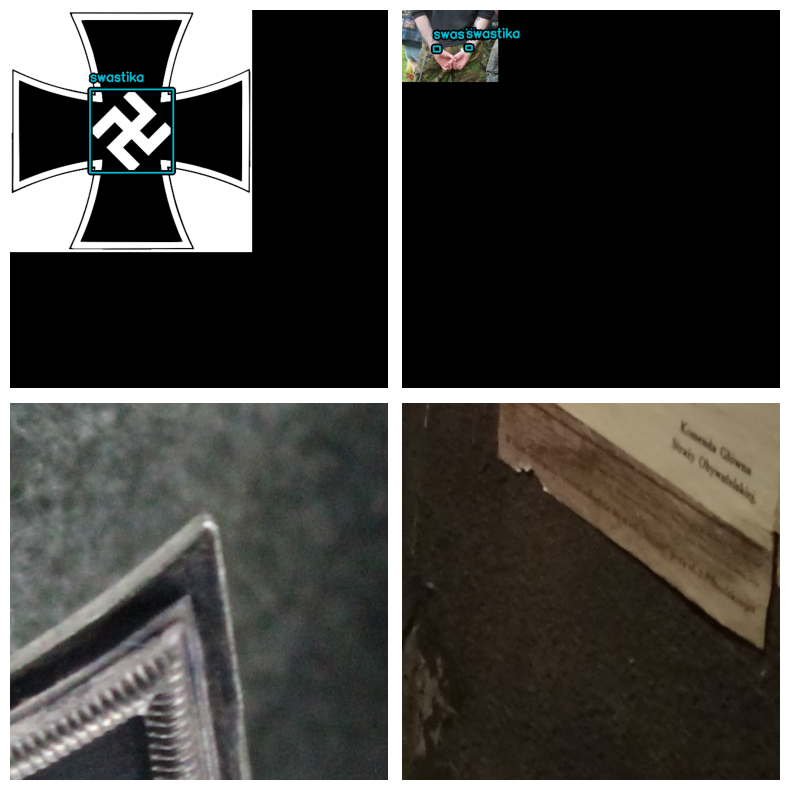

In [18]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images, verbose=2)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        pred_color=(255,0,0),
        class_mapping=train_ds_classes,
    )

model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualization_ds = prefetched_eval_ds.unbatch()
visualization_ds = visualization_ds.shuffle(buffer_size=3)
visualization_ds = visualization_ds.ragged_batch(4)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")